In [34]:
import pandas as pd
import numpy as np
import yfinance as yf
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from scipy.stats import zscore

In [42]:
import matplotlib.pyplot as plt

In [35]:
BGC_data = yf.download("GOLD", start="2021-01-01", end="2025-01-02")[['Close']]
BGC_data = BGC_data.dropna().reset_index()

BGC_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Close
Ticker,,GOLD
0,2021-01-04,21.925213
1,2021-01-05,21.622431
2,2021-01-06,21.818350
3,2021-01-07,22.058792
4,2021-01-08,21.346357


In [36]:
BGC_data.columns = ['ds', 'y']
BGC_data.head()

,ds,y
0,2021-01-04,21.925213
1,2021-01-05,21.622431
2,2021-01-06,21.818350
3,2021-01-07,22.058792
4,2021-01-08,21.346357


In [37]:
def data_cleaner(df):
    """Removes outliers and fills missing values"""
    df['y'] = df['y'].interpolate(method='linear')
    df = df[(df['y'] > df['y'].quantile(0.01)) & (df['y'] < df['y'].quantile(0.99))]
    return df

BGC_data = data_cleaner(BGC_data)

BGC_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 983 entries, 0 to 1004
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      983 non-null    datetime64[ns]
 1   y       983 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.0 KB


In [39]:
BGC_data['y'] = np.log(BGC_data['y'])  
BGC_data = BGC_data[(np.abs(zscore(BGC_data['y'])) < 3)]

BGC_data['SMA_90'] = BGC_data['y'].rolling(window=90).mean()
BGC_data['SMA_180'] = BGC_data['y'].rolling(window=180).mean()
BGC_data['volatility'] = BGC_data['y'].pct_change().rolling(window=10).std()
BGC_data = BGC_data.dropna()

BGC_data

,ds,y,SMA_90,SMA_180,volatility
369,2022-06-22,2.900661,3.008593,2.930917,0.009497
370,2022-06-23,2.855857,3.008652,2.931031,0.010293
371,2022-06-24,2.868180,3.008938,2.931261,0.010226
372,2022-06-27,2.881930,3.009028,2.931579,0.008569
373,2022-06-28,2.855857,3.008864,2.931819,0.007874
...,...,...,...,...,...
1000,2024-12-24,2.754297,2.938192,2.891663,0.008221
1001,2024-12-26,2.756205,2.935469,2.891009,0.007031
1002,2024-12-27,2.752386,2.932594,2.890290,0.006819
1003,2024-12-30,2.738256,2.929449,2.889548,0.006647


In [40]:
model = Prophet(changepoint_prior_scale=0.1) 
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_regressor('SMA_90')
model.add_regressor('SMA_180')
model.add_regressor('volatility')
model.add_seasonality(name='quarterly', period=90, fourier_order=8)
model.fit(BGC_data)



00:23:52 - cmdstanpy - INFO - Chain [1] start processing
00:23:52 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
future_df = model.make_future_dataframe(periods=60)
future_df['SMA_90'] = BGC_data['SMA_90'].iloc[-1]
future_df['SMA_180'] = BGC_data['SMA_180'].iloc[-1]
future_df['volatility'] = BGC_data['volatility'].iloc[-1]
forecast = model.predict(future_df)


In [43]:
actual = BGC_data['y'][-60:]
predictions = forecast['yhat'][-60:]
MAE = mean_absolute_error(actual, predictions)
print(f"Prophet MAE: {MAE:.2f}")

Prophet MAE: 0.45


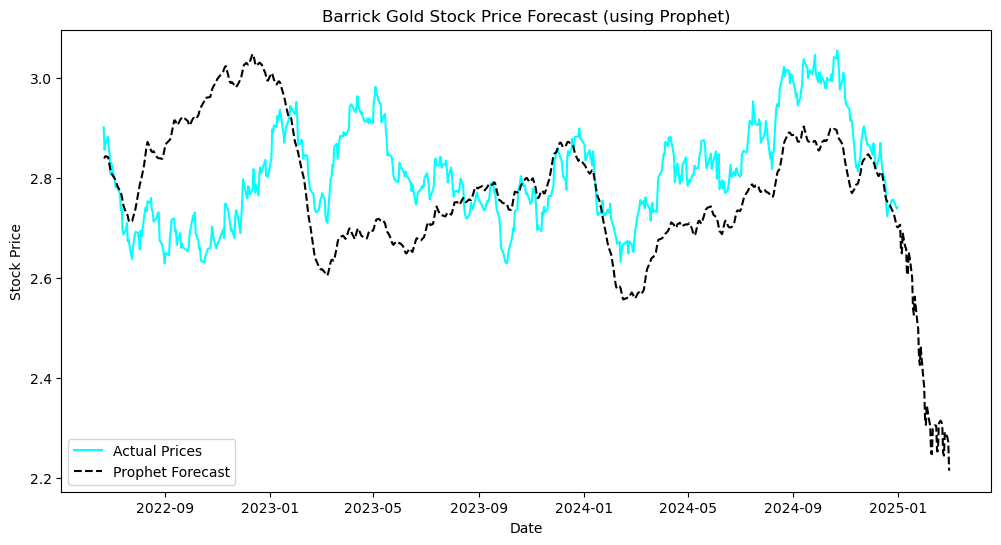

In [44]:
plt.figure(figsize=(12,6))
plt.plot(BGC_data['ds'], BGC_data['y'], label='Actual Prices', color='cyan')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='black', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Barrick Gold Stock Price Forecast (using Prophet)')
plt.legend()
plt.show()